## Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

## Data

In [2]:
# import dataset
supermarket_data = pd.read_csv('supermarket_sales - Sheet1.csv', index_col=0)

In [3]:
# view dataset
supermarket_data.head()

,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
Invoice ID,,,,,,,,,,,,,,,,
750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [4]:
# basic info
print('There are '
    f'{supermarket_data.shape[0]} rows and '
    f'{supermarket_data.shape[1]} columns '
    'in the supermarket_sales dataset.'
)
print('The datatypes in the supermarket_sales dataset are: ')
display(supermarket_data.dtypes)

There are 1000 rows and 16 columns in the supermarket_sales dataset.
The datatypes in the supermarket_sales dataset are: 


Branch                      object
City                        object
Customer type               object
Gender                      object
Product line                object
Unit price                 float64
Quantity                     int64
Tax 5%                     float64
Total                      float64
Date                        object
Time                        object
Payment                     object
cogs                       float64
gross margin percentage    float64
gross income               float64
Rating                     float64
dtype: object

Some features appear inaccurate or unnecessary.

- Branch - Unnecessary (duplicate of City)
- Tax - Unnecessary (percentage of total)
- Total - Unnecessary (includes tax)
- cogs - inaccurate, duplicate (total unit price * quantity)
- gross margin percentage - inaccurate, constant value column
- gross income - inaccurate (duplicate of tax)

In [5]:
# unique values for 'Branch'
print('Branches:', supermarket_data['Branch'].unique())
# unique values for 'City'
print('Cities:', supermarket_data['City'].unique())
# unique values in Branch map to more than one unique value in Cities
# if false, features are duplicates
print(supermarket_data.groupby('Branch').City.nunique().gt(1).any())

Branches: ['A' 'C' 'B']
Cities: ['Yangon' 'Naypyitaw' 'Mandalay']
False


In [6]:
# confirm tax is 5% of total
# tax - (unit price * quantity)
# true if all values are zero
tax_is_pct = (supermarket_data['Tax 5%'] - \
    ((supermarket_data['Unit price'] * supermarket_data['Quantity'])\
     .apply(lambda x: x * 0.05))
).round(4)
print('duplicate' if not any(tax_is_pct) else 'inequal values exist')

duplicate


In [7]:
# confirm total is (unit price * quantity) + tax
# true if all values are zero
total_calc = \
    (supermarket_data['Total']\
        - (
            (supermarket_data['Unit price'] * supermarket_data['Quantity'])
            + supermarket_data['Tax 5%']
        )
    ).round(4)
print('duplicate' if not any(total_calc) else 'inequal values exist')

duplicate


In [8]:
# confirm cogs is (unit price * quantity)
# true if all values are zero
cogs_calc = \
    (supermarket_data['cogs']\
        - (
            supermarket_data['Unit price'] * supermarket_data['Quantity']
        )
    ).round(4)
print('duplicate' if not any(cogs_calc) else 'inequal values exist')

duplicate


In [9]:
# check unique values in 'gross margin percentage'
supermarket_data['gross margin percentage'].unique()

array([4.76190476])

In [10]:
# check 'gross income' is duplicate of tax column
all(supermarket_data['Tax 5%'] == supermarket_data['gross income'])

True

These features are unnecessary and can be removed.

Some features can be modified or engineered.
- Customer type - Boolean encoding to "member"
- Gender - Boolean encoding to "male"
- Date of purchase and Purchase time - Datetime encoding to "saledate"
- Unit price and Quantity - engineer "sale_gross"

In [11]:
# choose features, datetime conversion, set datetime to index
supermarket_data = pd.read_csv(
    'supermarket_sales - Sheet1.csv',
    usecols=[
        'City',
        'Customer type',
        'Gender',
        'Product line',
        'Unit price',
        'Quantity',
        'Payment',
        'Rating',
        'Date',
        'Time'
    ],
    parse_dates={'saledate': ['Date', 'Time']},
    index_col='saledate'
).sort_index()

# modify member and gender features to boolean
supermarket_data['member'] = supermarket_data['Customer type'].map(
    {'Normal': 0, 'Member': 1}
)
supermarket_data['male'] = supermarket_data['Gender'].map(
    {'Female': 0, 'Male': 1}
)
supermarket_data = supermarket_data.drop(
    columns=[
        'Customer type',
        'Gender'
    ]
)

# engineer gross sales feature
supermarket_data['sale_gross'] = (
    supermarket_data['Unit price'] * supermarket_data['Quantity']
)

# rename columns
supermarket_data = supermarket_data.rename(
    columns={
        'Invoice ID': 'invoice',
        'City': 'branch',
        'Product line': 'category',
        'Unit price': 'unit_price',
        'Quantity': 'quantity',
        'Payment': 'payment_type',
        'Rating': 'rating'
    }
)

In [12]:
# customized dataset
supermarket_data.head()

,branch,category,unit_price,quantity,payment_type,rating,member,male,sale_gross
saledate,,,,,,,,,
2019-01-01 10:39:00,Yangon,Sports and travel,72.61,6,Credit card,6.9,0,1,435.66
2019-01-01 11:36:00,Mandalay,Food and beverages,84.63,10,Credit card,9.0,1,0,846.30
2019-01-01 11:40:00,Naypyitaw,Sports and travel,29.22,6,Ewallet,5.0,1,0,175.32
2019-01-01 11:43:00,Naypyitaw,Health and beauty,62.87,2,Cash,5.0,0,1,125.74
2019-01-01 13:55:00,Yangon,Fashion accessories,65.74,9,Cash,7.7,0,0,591.66


In [13]:
supermarket_data.shape

(1000, 9)

In [14]:
# observation times
print('The first observed sale was recorded: ')
print(supermarket_data.head(1).index.strftime('%B %d, %Y, %r').values[0])
print('The last observed sale was recorded: ')
print(supermarket_data.tail(1).index.strftime('%B %d, %Y, %r').values[0])
observation_timedelta = supermarket_data.index[-1] - supermarket_data.index[0]
print(f'The observation lasted a total of {observation_timedelta.days + 1} days.')

The first observed sale was recorded: 
January 01, 2019, 10:39:00 AM
The last observed sale was recorded: 
March 30, 2019, 08:37:00 PM
The observation lasted a total of 89 days.


## Exploration

The Basics:
- Daily sales distribution by branch
- category sales by branch
- member purchase ratios by branch
- gender purchase ratios by branch

KPIs:
- Characteristics of highest sales
- Are sale grosses higher for members?
- What category do members purchase most?
- What category has the highest sales?
- Which branch has the highest average rating?

Other questions:
- Is Payment related to Rating?
- Do electronic payments average higher sales than cash?
- Are members more likely to use credit cards? Ewallets?
- What days of the week have the highest overall sales?
- What times of day have the highest overall sales?

### Basics

In [15]:
# total daily sales by branch
branch_daily_sales = pd.pivot_table(
    data= supermarket_data,
    values= 'sale_gross',
    index= supermarket_data.index.date,
    columns= 'branch',
    aggfunc= 'sum'
)

In [16]:
branch_daily_sales.sample()

branch,Mandalay,Naypyitaw,Yangon
2019-03-07,283.72,734.92,351.13


In [17]:
# daily sales summary
branch_daily_sales.describe()

branch,Mandalay,Naypyitaw,Yangon
count,86.000000,88.000000,89.000000
mean,1176.053953,1196.631023,1136.440562
std,854.076047,726.619161,703.480642
min,29.520000,37.000000,148.670000
25%,461.135000,612.367500,569.600000
50%,980.540000,1215.710000,993.050000
75%,1660.422500,1567.520000,1594.550000
max,3402.150000,3459.880000,3099.510000


In [18]:
# days when any branch had no transactions
branch_daily_sales[branch_daily_sales.isna().any(axis=1)]

branch,Mandalay,Naypyitaw,Yangon
2019-01-11,NaN,431.71,1582.54
2019-01-23,NaN,3459.88,2248.87
2019-02-01,NaN,1459.62,868.51
2019-03-22,1001.04,NaN,2026.72


In [19]:
sns.set_theme()

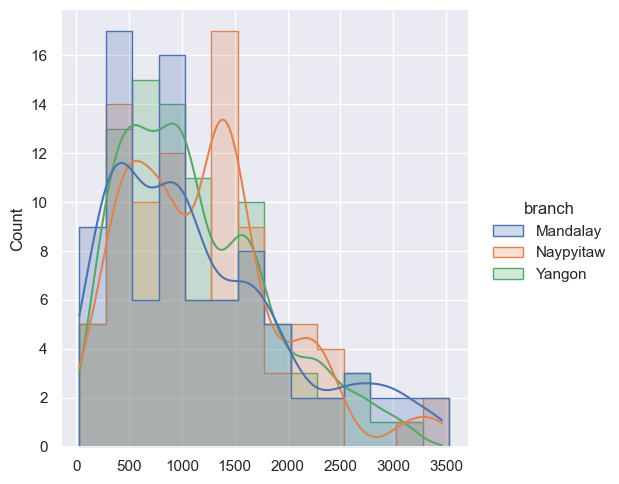

In [20]:
# daily sales distribution by branch
sns.displot(
    data= branch_daily_sales,
    binwidth= 250,
    element= 'step',
    kde= True,
    kde_kws= {'bw_adjust': 0.6}
);

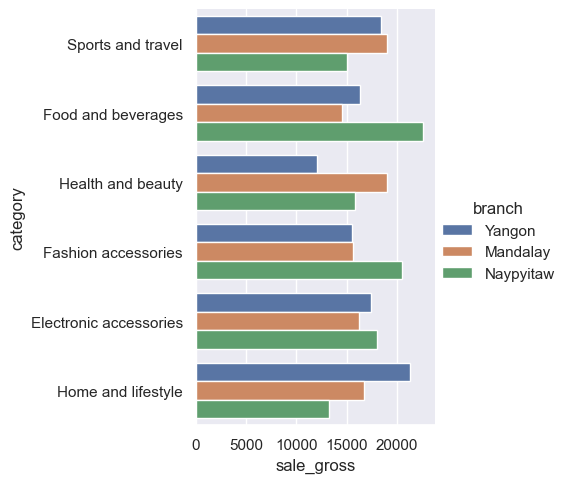

In [21]:
# category sales by branch
sns.catplot(
    data= supermarket_data,
    x= 'sale_gross',
    y= 'category',
    hue= 'branch',
    kind= 'bar',
    estimator= 'sum',
    errorbar= None
);

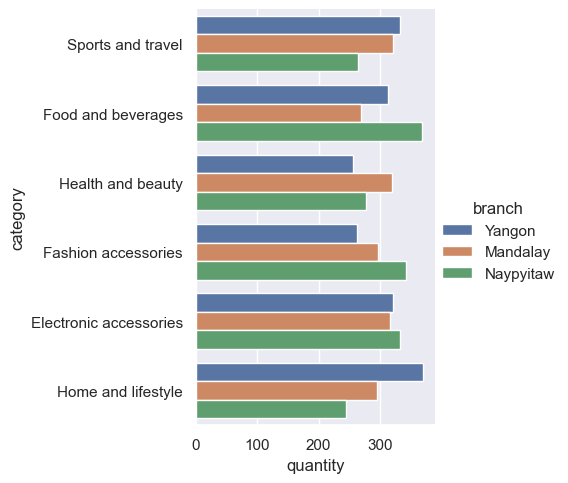

In [22]:
# quantity gross by branch
sns.catplot(
    data= supermarket_data,
    x= 'quantity',
    y= 'category',
    hue= 'branch',
    kind= 'bar',
    estimator= 'sum',
    errorbar= None
);

- 'Food and beverages' significantly higher for Naypyitaw
- 'Fashion accessories' significantly higher for Naypyitaw
- 'Home and lifestyle' significantly higher for Yangon
- 'Health and beauty' moderately higher for Mandalay
- 'Sports and travel' and 'Home and lifestyle' low-performers for Naypyitaw
- 'Health and beauty' low-performer for Yangon

In [23]:
member_pct_by_branch = pd.DataFrame(
    supermarket_data[['branch', 'member']]
    .groupby('branch')
    .value_counts(normalize=True)
    .reset_index()
    .rename({0: 'proportion'}, axis=1)
)
member_pct_by_branch['proportion'] = member_pct_by_branch['proportion'].apply(
    lambda x: x * 100
)

In [24]:
member_pct_by_branch

,branch,member,proportion
0,Mandalay,0,50.301205
1,Mandalay,1,49.698795
2,Naypyitaw,1,51.524390
3,Naypyitaw,0,48.475610
4,Yangon,0,50.882353
5,Yangon,1,49.117647


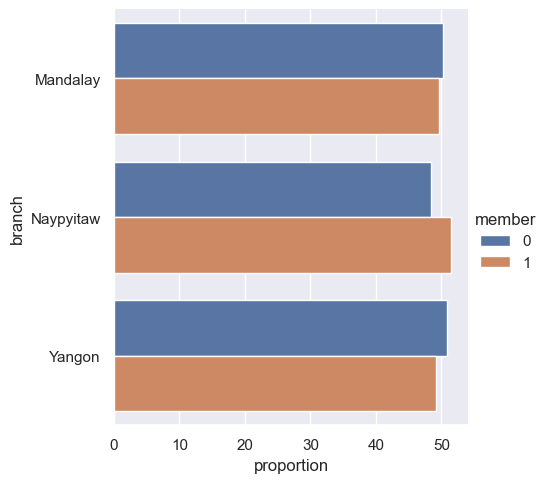

In [25]:
# member purchase ratios by branch
sns.catplot(
    data= member_pct_by_branch,
    y= 'branch',
    x= 'proportion',
    hue= 'member',
    kind= 'bar',
    orient= 'horizontal'
);

No apparent significant differences.

In [26]:
male_pct_by_branch = pd.DataFrame(
    supermarket_data[['branch', 'male']]
    .groupby('branch')
    .value_counts(normalize=True)
    .reset_index()
    .rename({0: 'proportion'}, axis=1)
)
male_pct_by_branch['proportion'] = male_pct_by_branch['proportion'].apply(
    lambda x: x * 100
)

In [27]:
male_pct_by_branch

,branch,male,proportion
0,Mandalay,1,51.204819
1,Mandalay,0,48.795181
2,Naypyitaw,0,54.268293
3,Naypyitaw,1,45.731707
4,Yangon,1,52.647059
5,Yangon,0,47.352941


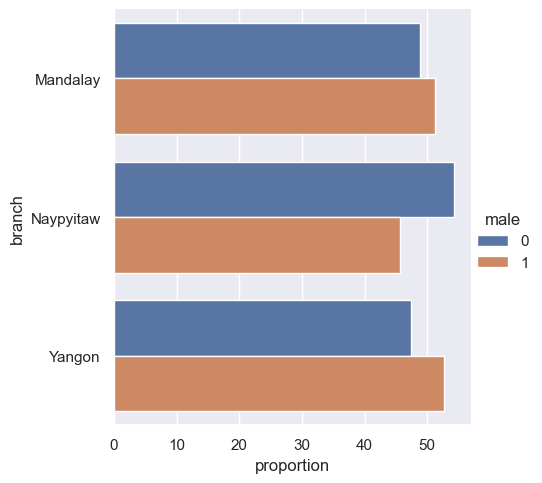

In [28]:
# gender purchase ratios by branch
sns.catplot(
    data= male_pct_by_branch,
    y= 'branch',
    x= 'proportion',
    hue= 'male',
    kind= 'bar',
    orient= 'horizontal'
);

- There are a high number of female transactions at the Naypyitaw branch. There are also a high number of sales in both 'food & beverages' and 'fashion accessories' at the Naypyitaw branch. This is worth further investigation.
- There are slightly more male than female transactions at Yangon.

### KPIs

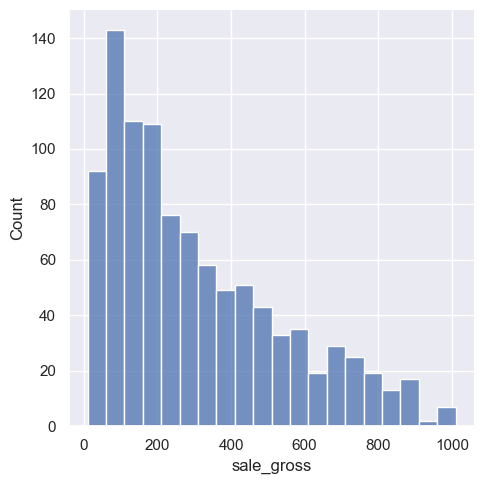

In [29]:
# distribution of sale_gross
sns.displot(
    data= supermarket_data,
    x= 'sale_gross',
    kind= 'hist',
    binwidth= 50
);

In [30]:
# observations with sale_gross > 800
high_sales = supermarket_data.loc[supermarket_data['sale_gross'] > 750.00]

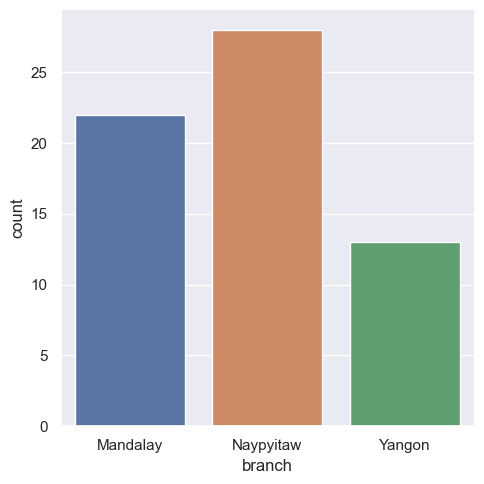

In [31]:
# high value transactions by branch
sns.catplot(
    data= high_sales,
    x= 'branch',
    kind= 'count'
);

Most high value transactions occur at Naypyitaw branch.

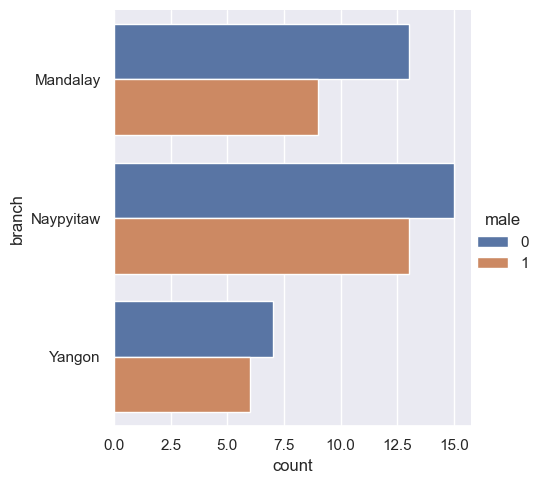

In [32]:
# high value transactions by gender
sns.catplot(
    data= high_sales,
    y= 'branch',
    hue= 'male',
    kind= 'count',
    orient= 'horizontal'
);

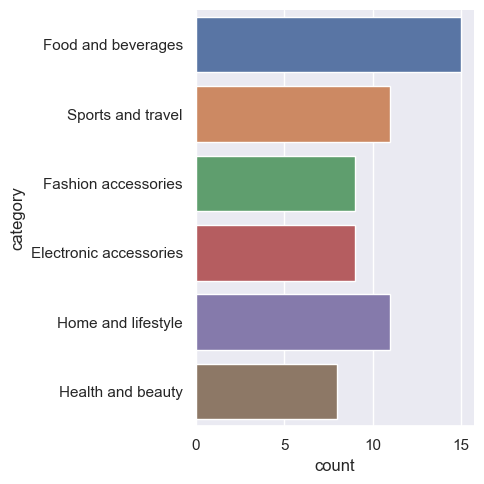

In [33]:
# high value transactions by category
sns.catplot(
    data= high_sales,
    y= 'category',
    kind= 'count'
);

Most high value transactions occur in 'Food and beverages'.

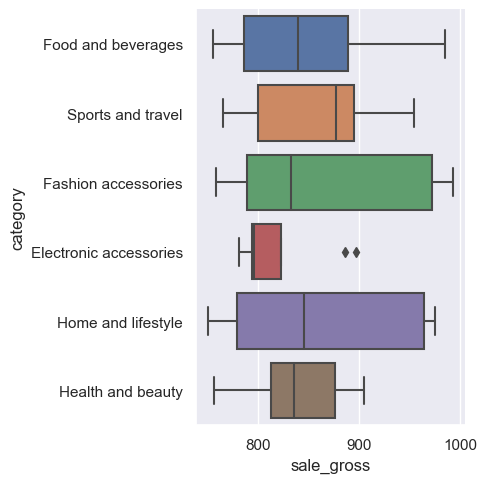

In [34]:
# high value amounts by category
sns.catplot(
    data= high_sales,
    y= 'category',
    x= 'sale_gross',
    kind= 'box'
);

'Electronic accessories' have lowest overall distribution of high-value transactions.
'Sports and travel' has the highest median sale_gross of high-value transactions.

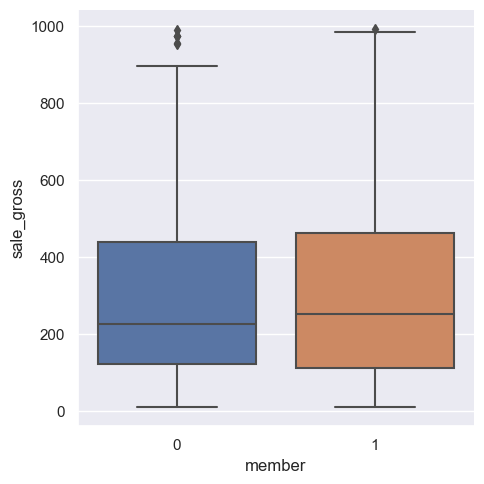

In [35]:
# member vs non-member sale gross distribution
sns.catplot(
    data= supermarket_data,
    x= 'member',
    y= 'sale_gross',
    kind= 'box'
);

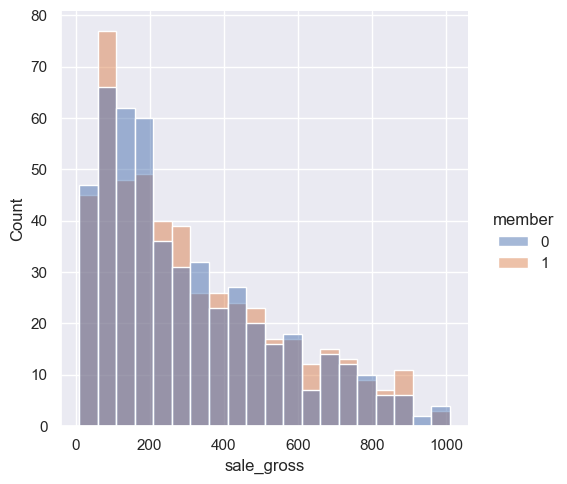

In [36]:
# distribution of sale totals for members vs non-members
sns.displot(
    data= supermarket_data,
    x= 'sale_gross',
    hue= 'member',
    binwidth= 50,
    kind= 'hist'
);

Further analysis required: two-sample t-test and two standard deviations F-test for member vs non-member.
- Distributions are skewed, will need a transformation (log?) to normalize. How will transformation affect outcome of tests? Still valid?

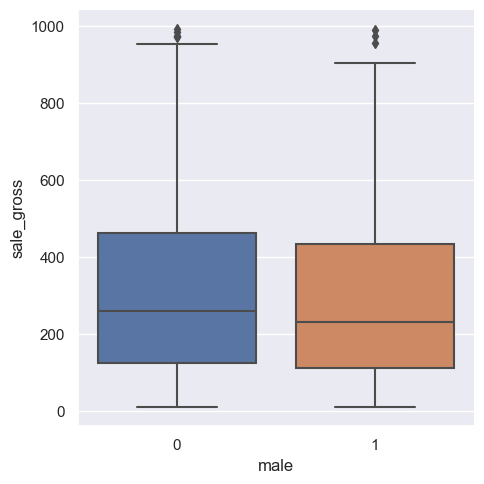

In [37]:
# male vs female sale gross distribution
sns.catplot(
    data= supermarket_data,
    x= 'male',
    y= 'sale_gross',
    kind= 'box'
);

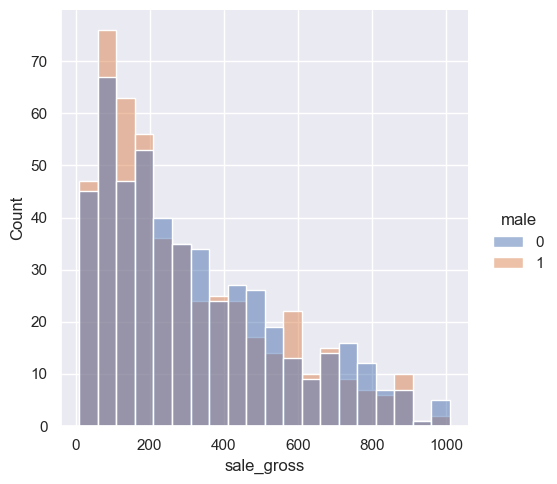

In [38]:
# distribution of sale totals for males vs females
sns.displot(
    data= supermarket_data,
    x= 'sale_gross',
    hue= 'male',
    binwidth= 50,
    kind= 'hist'
);

Further analysis required: two-sample t-test and two standard deviations F-test for male vs female.
- Distributions are skewed, will need a transformation (log?) to normalize. How will transformation affect outcome of tests? Still valid?

In [39]:
member_purchases = supermarket_data.loc[supermarket_data['member']==1]

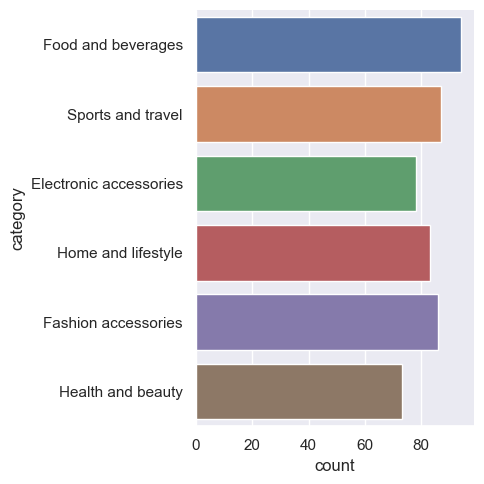

In [40]:
# members: number of purchases by category
sns.catplot(
    data= member_purchases,
    y= 'category',
    kind= 'count'
);

In [41]:
member_units_by_category = member_purchases.pivot_table(
    values= 'quantity',
    index= 'category',
    aggfunc= 'sum'
).reset_index()

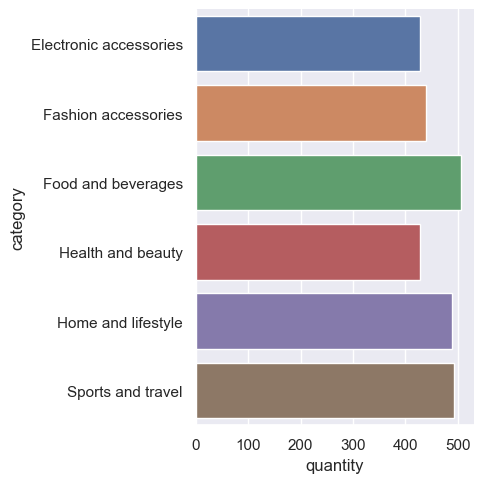

In [42]:
# members: number of units purchased by category
sns.catplot(
    data= member_units_by_category,
    y= 'category',
    x= 'quantity',
    kind= 'bar'
);

In [43]:
gross_sales_by_category = supermarket_data.pivot_table(
    values= 'sale_gross',
    index= 'category',
    aggfunc= 'sum'
).reset_index()

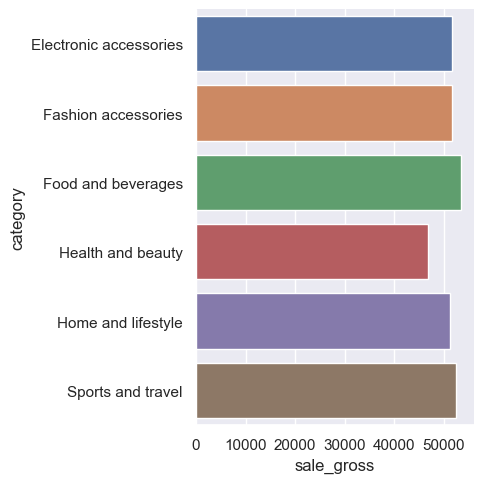

In [44]:
# total sales by category
sns.catplot(
    data= gross_sales_by_category,
    y= 'category',
    x= 'sale_gross',
    kind= 'bar'
);

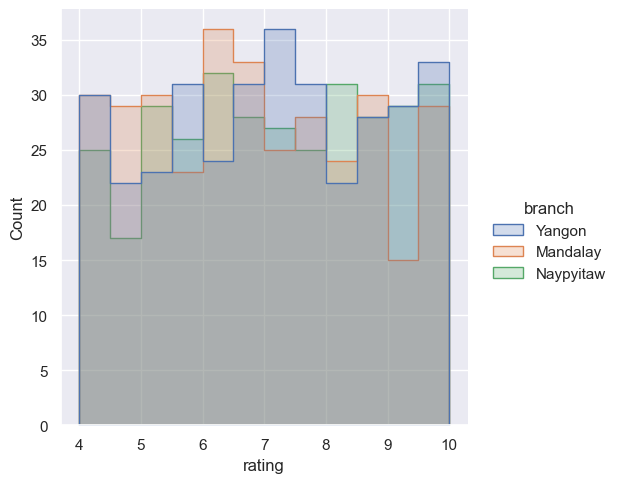

In [45]:
# rating distributions by branch
sns.displot(
    data= supermarket_data,
    x= 'rating',
    binwidth= 0.5,
    hue= 'branch',
    element= 'step'
);

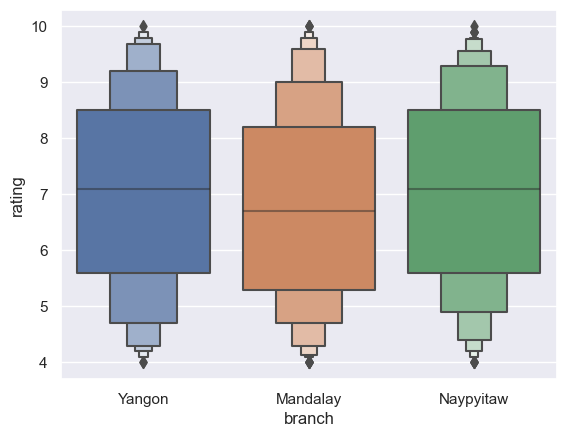

In [46]:
# rating distributions by branch
sns.boxenplot(
    data= supermarket_data,
    x= 'branch',
    y= 'rating'
);

In [47]:
avg_rating_by_branch = supermarket_data.pivot_table(
    values= 'rating',
    index= 'branch',
    aggfunc= 'mean'
).reset_index()

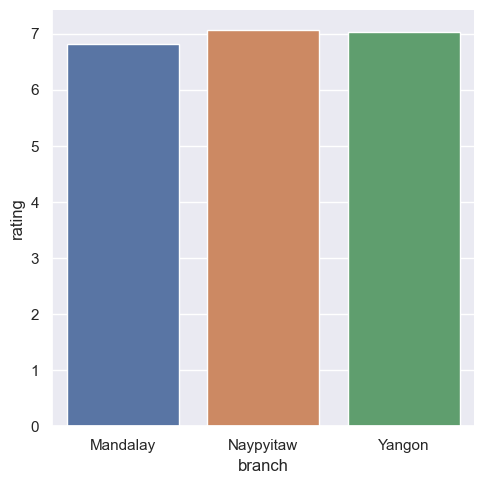

In [48]:
# average rating by branch
sns.catplot(
    data= avg_rating_by_branch,
    x= 'branch',
    y= 'rating',
    kind= 'bar'
);

In [49]:
avg_member_rating_by_branch = supermarket_data.pivot_table(
    values= 'rating',
    columns= ['member', 'branch'],
    aggfunc= 'mean'
).melt().rename(columns={'value': 'rating'})

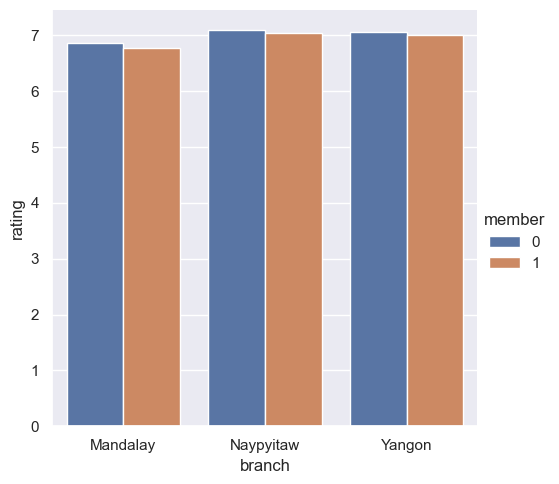

In [50]:
# average member vs non-member rating by branch
sns.catplot(
    data= avg_member_rating_by_branch,
    x= 'branch',
    y= 'rating',
    hue= 'member',
    kind= 'bar'
);

### Other Questions

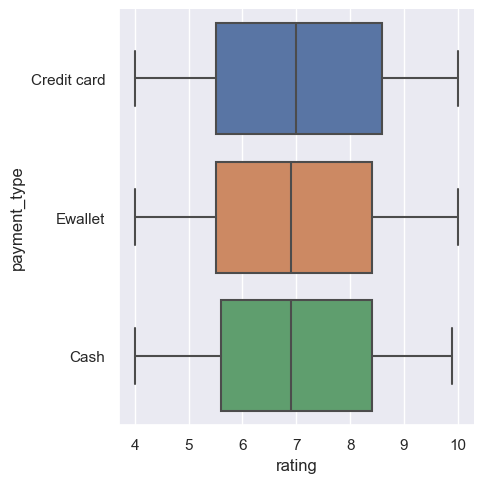

In [51]:
# rating by payment
sns.catplot(
    data= supermarket_data,
    y= 'payment_type',
    x= 'rating',
    kind= 'box'
);

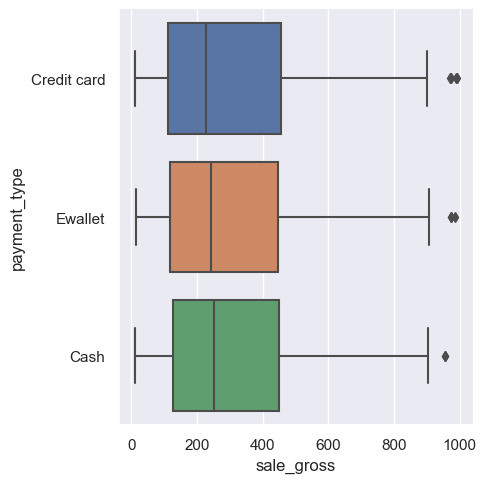

In [52]:
# gross sales by payment
sns.catplot(
    data= supermarket_data,
    y= 'payment_type',
    x= 'sale_gross',
    kind= 'box'
);

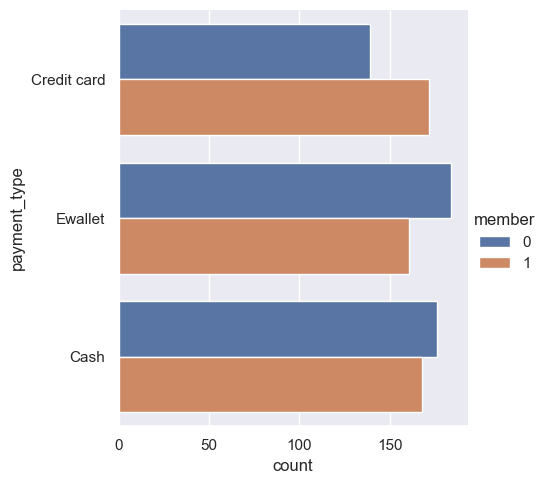

In [53]:
# payment type for member vs non-member
sns.catplot(
    data= supermarket_data,
    y= 'payment_type',
    hue= 'member',
    kind= 'count'
);

In [54]:
# add day of week to supermarket_data
supermarket_data['dow'] = supermarket_data.index.day_name()

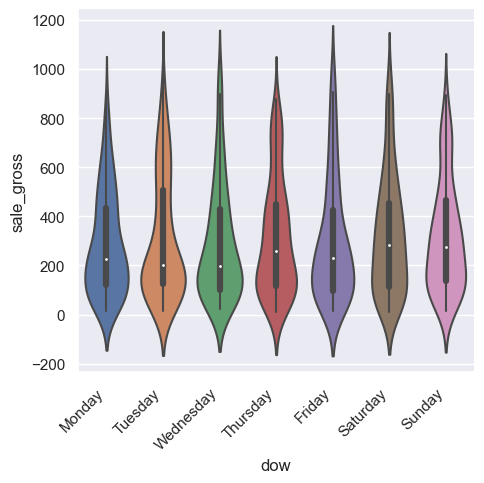

In [55]:
# sales by day of week
g = sns.catplot(
    data= supermarket_data,
    x = 'dow',
    y= 'sale_gross',
    kind= 'violin',
    order= [
        'Monday',
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday',
        'Sunday'
    ]
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

Test if mean sales on any particular day are significantly higher than the average. May need to transform the data to normalize the skew.

In [56]:
daily_sales_total = supermarket_data.groupby(pd.Grouper(freq='D')).sum(numeric_only=True)

In [57]:
sns.set(rc= {'figure.figsize': (12, 3)})

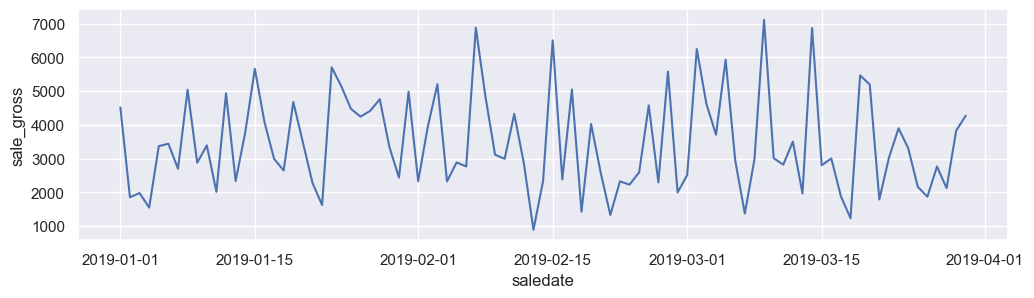

In [58]:
# total sales by date

sns.lineplot(
    data= daily_sales_total,
    x= 'saledate',
    y= 'sale_gross'
);

In [59]:
daily_sales_by_branch = (
    supermarket_data
    .groupby([
        pd.Grouper(freq='D'),
        'branch'
    ])
    .sum(numeric_only=True)
    .reset_index()
)

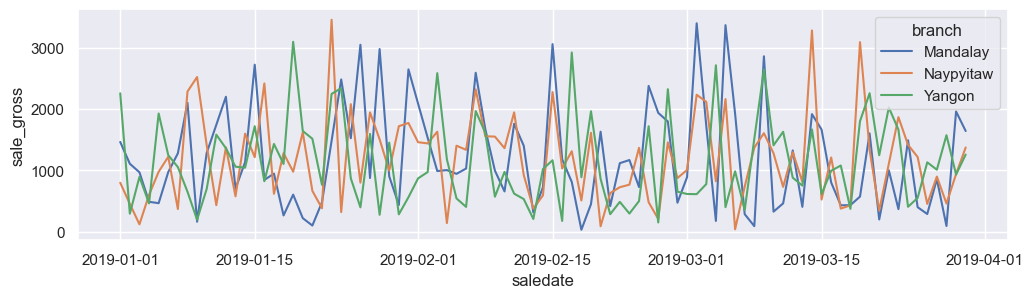

In [60]:
# total sales by date by branch
sns.lineplot(
    data= daily_sales_by_branch,
    x= 'saledate',
    y= 'sale_gross',
    hue= 'branch'
);

In [61]:
sales_by_hour = (
    supermarket_data
    .groupby([
        pd.Grouper(freq='H')
    ])
    .sum(numeric_only=True)
)
sales_by_hour['hour'] = sales_by_hour.index.hour
sales_by_hour = sales_by_hour.loc[sales_by_hour['sale_gross'] != 0.0]

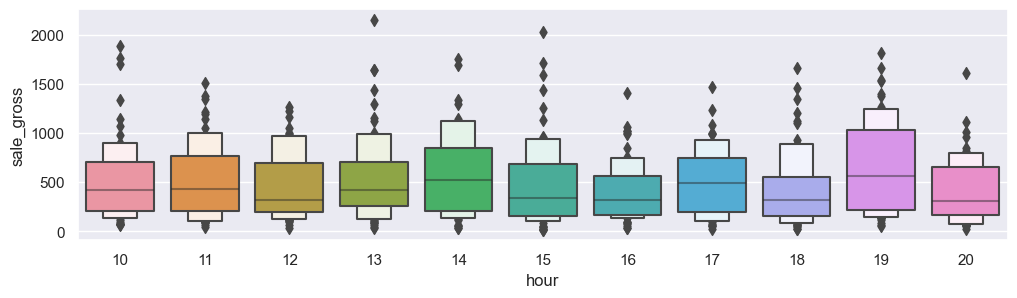

In [62]:
# sale distributions by hour
sns.boxenplot(
    data= sales_by_hour,
    y= 'sale_gross',
    x= 'hour'
);

In [63]:
sns.set_theme()

## Exploration 2: Additional Analyses

1. Sales
    - Relationship between unit price and quantity sold
2. Customer Behavior
    - Further explore rating variable
    - Further explore purchasing patterns of members vs non-members
    - Total sales price vs rating
3. Time Series
    - Further explore time series trends

### Sales

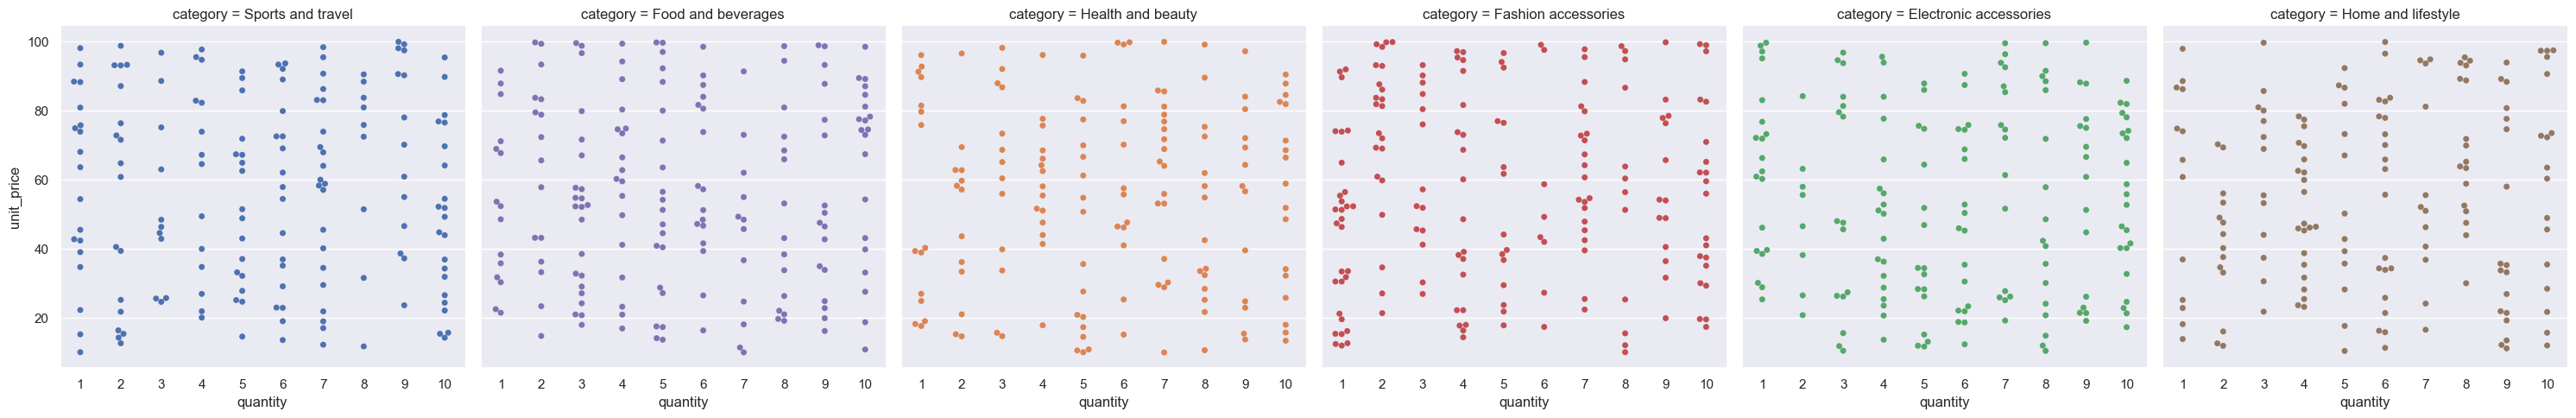

In [64]:
# relationship between unit price and quantity sold by category
sns.catplot(
    data= supermarket_data,
    x= 'quantity',
    y= 'unit_price',
    col= 'category',
    hue= 'category',
    kind= 'swarm'
);

No apparent relationship.

In [65]:
# numeric correlations
supermarket_data.corr(numeric_only=True)

,unit_price,quantity,rating,member,male,sale_gross
unit_price,1.000000,0.010778,-0.008778,0.020238,0.015445,0.633962
quantity,0.010778,1.000000,-0.015815,0.016763,-0.074258,0.705510
rating,-0.008778,-0.015815,1.000000,-0.018889,0.004800,-0.036442
member,0.020238,0.016763,-0.018889,1.000000,-0.039996,0.019670
male,0.015445,-0.074258,0.004800,-0.039996,1.000000,-0.049451
sale_gross,0.633962,0.705510,-0.036442,0.019670,-0.049451,1.000000


### Customer Behavior

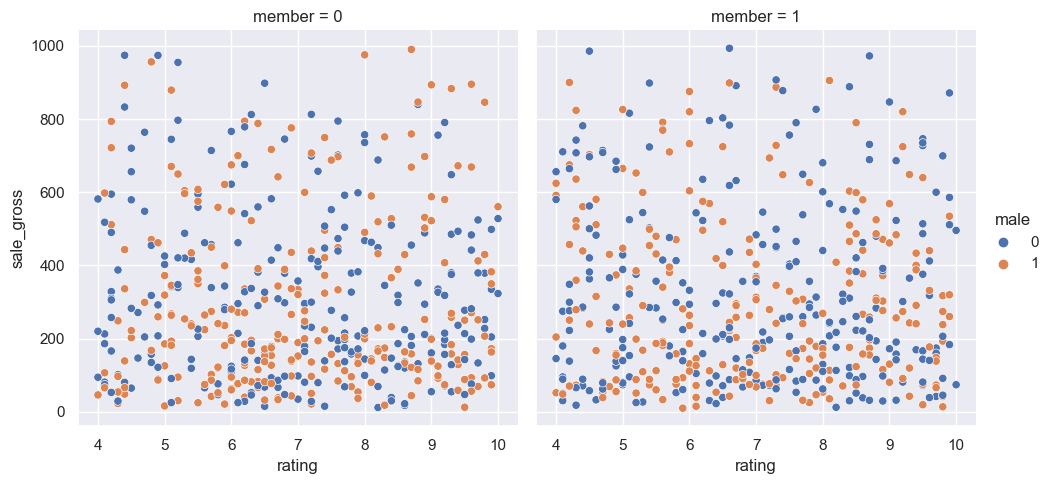

In [66]:
# rating vs sale gross, by member, by gender
sns.relplot(
    data= supermarket_data,
    x= 'rating',
    y= 'sale_gross',
    col= 'member',
    hue= 'male'
);

No apparent relationship.

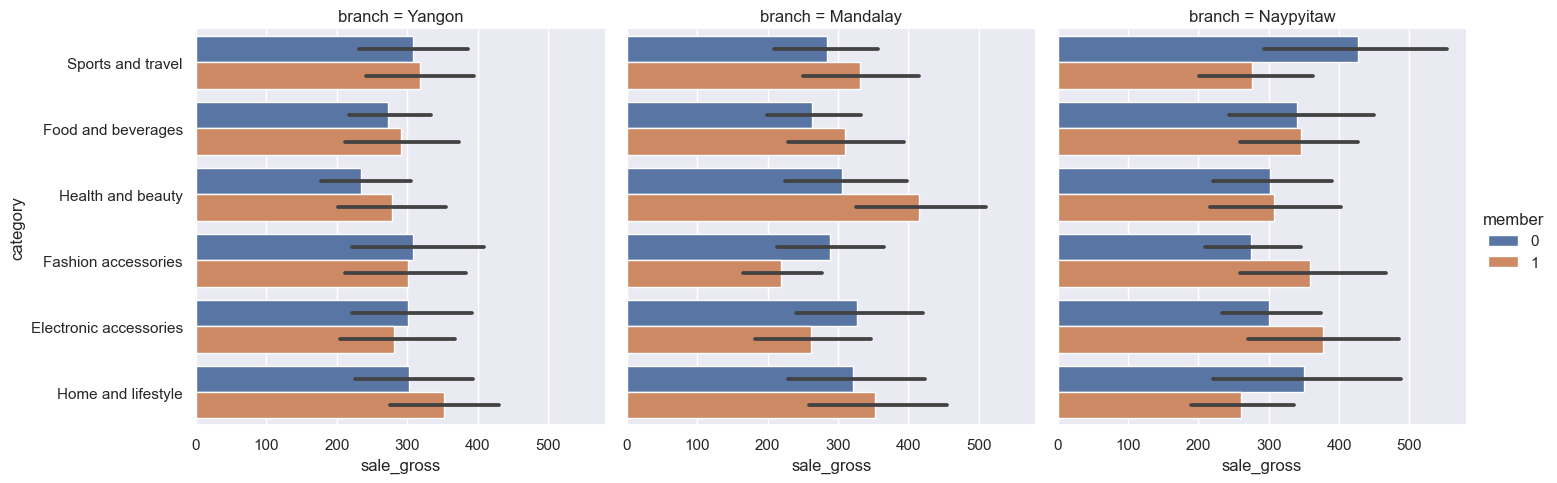

In [67]:
# average sale gross, by member, by category, by branch
sns.catplot(
    data= supermarket_data,
    y= 'category',
    hue= 'member',
    x= 'sale_gross',
    col= 'branch',
    kind= 'bar'
);

Some insights here.
1. Yangon:
    - 'Home and lifestyle' and 'Health and beauty' slightly higher for members
2. Mandalay:
    - 'Sports and travel' and 'Food and beverages' slightly higher for members
    - 'Fashion accessories' and 'Electronic accessories' moderately higher for non-members
    - 'Health and beauty' significantly higher for members
3. Naypyitaw:
    - 'Fashion accessories' and 'Electronic accessories' moderately higher for members
    - 'Home and lifestyle' significantly higher for non-members
    - 'Sports and travel' significantly higher for non-members

### Time Series

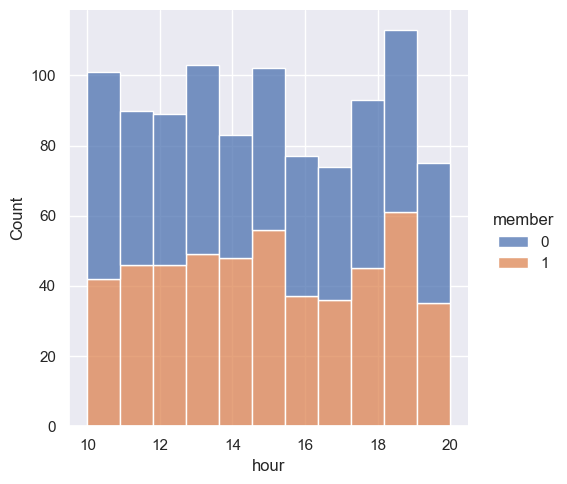

In [68]:
# total member vs non-member transactions by hour
sns.displot(
    data= supermarket_data,
    x= supermarket_data.index.hour,
    hue= 'member',
    multiple= 'stack'
)
plt.xlabel('hour');

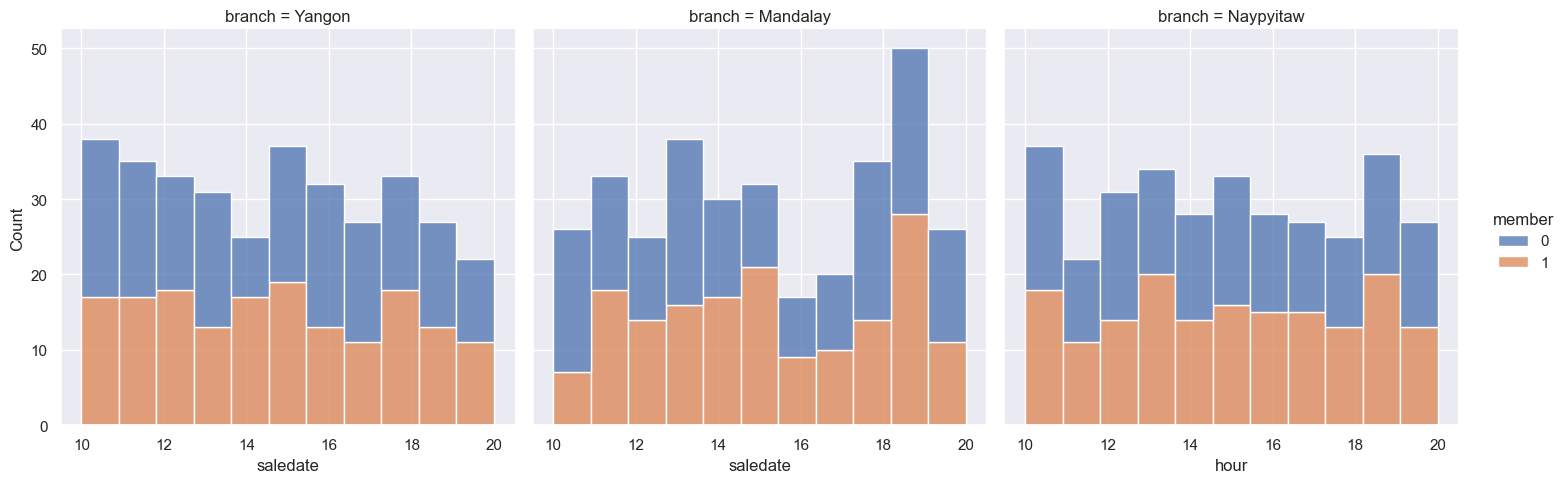

In [69]:
# total member vs non-member transactions by hour by branch
sns.displot(
    data= supermarket_data,
    x= supermarket_data.index.hour,
    hue= 'member',
    multiple= 'stack',
    col= 'branch'
)
plt.xlabel('hour');

Significant number of member transactions occur 1800-1900 hours at Mandalay branch. Mandalay also suffers worst performing hours at 1000, 1500 and 1600 hours.

In [70]:
daily_sales_by_category = (
    supermarket_data
    .groupby([
        pd.Grouper(freq='D'),
        'category'
    ])
    .sum(numeric_only=True)
    .reset_index()
)

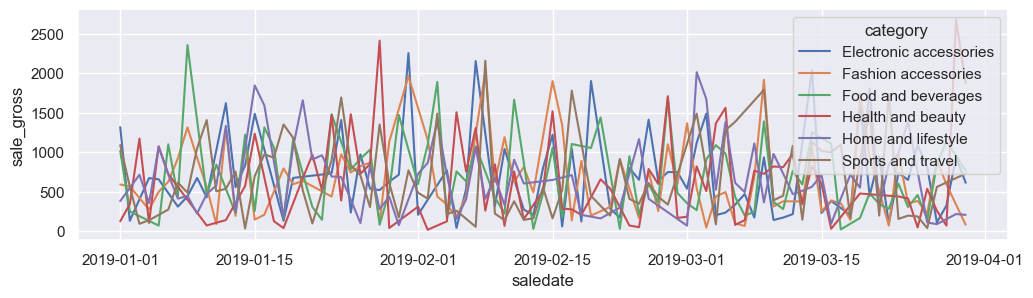

In [71]:
# daily sales by category
sns.lineplot(
    data= daily_sales_by_category,
    x= 'saledate',
    y= 'sale_gross',
    hue= 'category'
);

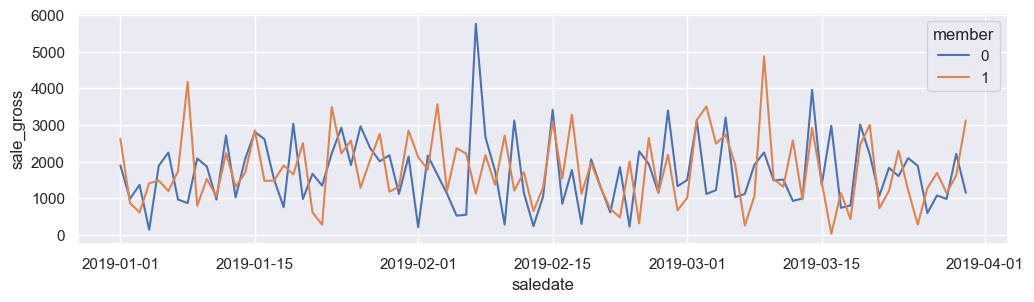

In [72]:
# daily sales by member
daily_sales_by_member = (
    supermarket_data
    .groupby([
        pd.Grouper(freq='D'),
        'member'
    ])
    .sum(numeric_only=True)
    .reset_index()
)
sns.lineplot(
    data= daily_sales_by_member,
    x= 'saledate',
    y= 'sale_gross',
    hue= 'member'
);

## Follow-Up

Analyses follow-up aggregated and separated by analysis category.

### CUSTOMER
- Further analysis required: sale_gross for member vs non-member.
- Further analysis required: sale_gross for male vs female.
- No significant differences in rating by member than non-member.
- No significant differences in payment types vs rating.
- No significant differences in payment types vs sale_gross.
- Members prefer to pay by credit card, non-members prefer to pay by Ewallet. Non-members slightly more likely to pay with cash than members. Need test to determine if significantly higher.


In [73]:
# get descriptive data for sale_gross by member vs non-member
sale_gross_member_mask = supermarket_data['member']==1
sale_gross_member = supermarket_data.loc[sale_gross_member_mask]['sale_gross']
sale_gross_nonmember = supermarket_data.loc[~sale_gross_member_mask]['sale_gross']
sale_gross_by_member = pd.DataFrame(
    {
        'member_sg': sale_gross_member.describe(),
        'nonmember_sg': sale_gross_nonmember.describe()
    }
)
display(sale_gross_by_member)

,member_sg,nonmember_sg
count,501.000000,499.000000
mean,312.182196,302.974148
std,236.184554,232.288381
min,10.170000,12.090000
25%,112.620000,123.080000
50%,253.360000,226.120000
75%,462.450000,440.580000
max,993.000000,989.800000


Null: member_sg == nonmember_sg <br>
Alternative: member_sg != nonmember_sg <br>
Alpha: 0.05

In [74]:
# mann-whitney U test for statistically significant difference
_, sgbm_p = mannwhitneyu(
    x= sale_gross_member,
    y= sale_gross_nonmember,
    alternative= 'two-sided'
)

print('The p-value is:', sgbm_p)

The p-value is: 0.5912341400583863


We cannot reject the null hypothesis.

Null: male_sg == female_sg <br>
Alternative: male_sg != female_sg <br>
Alpha: 0.05

In [75]:
# mann-whitney U test for statistically significant difference for male vs female transactions
sale_gross_male_mask = supermarket_data['male']==1
sale_gross_male = supermarket_data.loc[sale_gross_male_mask]['sale_gross']
sale_gross_female = supermarket_data.loc[~sale_gross_male_mask]['sale_gross']
_, sgbg_p = mannwhitneyu(
    x= sale_gross_male,
    y= sale_gross_female,
    alternative= 'two-sided'
)

print('The p-value is:', sgbg_p)

The p-value is: 0.10063092351245342


We cannot reject the null hypothesis.

Chi-square tests for each payment type by member to test for significant difference.

In [76]:
member_by_payment_type = supermarket_data.pivot_table(
    values= 'branch',
    index= 'member',
    columns= 'payment_type',
    aggfunc= 'count'
)

In [77]:
display(member_by_payment_type)

payment_type,Cash,Credit card,Ewallet
member,,,
0,176,139,184
1,168,172,161


For each payment type, we are testing independence of each payment type against other payment types. A p-value below alpha indicates a significant difference between members and non-members for the tested payment type. <br>
Alpha: 0.05

In [78]:
chi2_payments_p = chi2_contingency(member_by_payment_type)[1]
print('The p-value for member by payment types is:', chi2_payments_p)

The p-value for member by payment types is: 0.0736446179323698


No significant differences between members and non-members by payment type. More data would be helpful here. May also be useful to track if the credit cards used by members were supermarket credit cards or third-party credit cards.

### BRANCH
- 'Food and beverages' significantly higher for Naypyitaw
- 'Fashion accessories' significantly higher for Naypyitaw
- 'Home and lifestyle' significantly higher for Yangon
- 'Health and beauty' moderately higher for Mandalay
- 'Sports and travel' and 'Home and lifestyle' low-performers for Naypyitaw
- 'Health and beauty' low-performer for Yangon
- No apparent differences in member proportions by branch
- There are a high number of female transactions at the Naypyitaw branch. There are also a high number of sales in both 'food & beverages' and 'fashion accessories' at the Naypyitaw branch. This is worth further investigation.
- There are slightly more male than female transactions at Yangon.
- Most high value transactions occur at Naypyitaw branch.
- All thresholds of rating were lower for Mandalay branch. Need test to determine if significantly lower.
- For average sale gross, by member, by category, by branch:
1. Yangon:
    - 'Home and lifestyle' and 'Health and beauty' slightly higher for members
2. Mandalay:
    - 'Sports and travel' and 'Food and beverages' slightly higher for members
    - 'Fashion accessories' and 'Electronic accessories' moderately higher for non-members
    - 'Health and beauty' significantly higher for members
3. Naypyitaw:
    - 'Fashion accessories' and 'Electronic accessories' moderately higher for members
    - 'Home and lifestyle' significantly higher for non-members
    - 'Sports and travel' significantly higher for non-members

In [79]:
# get transactions for only Naypyitaw branch
naypyitaw = supermarket_data.loc[supermarket_data['branch'] == 'Naypyitaw']

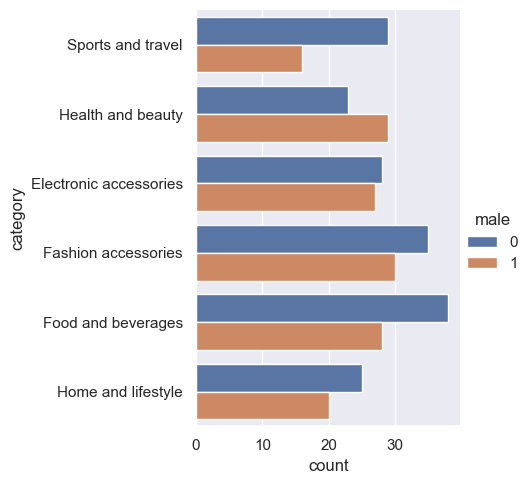

In [80]:
# female vs male transactions by category at Naypyitaw branch
sns.catplot(
    data= naypyitaw,
    y= 'category',
    hue = 'male',
    kind= 'count'
);

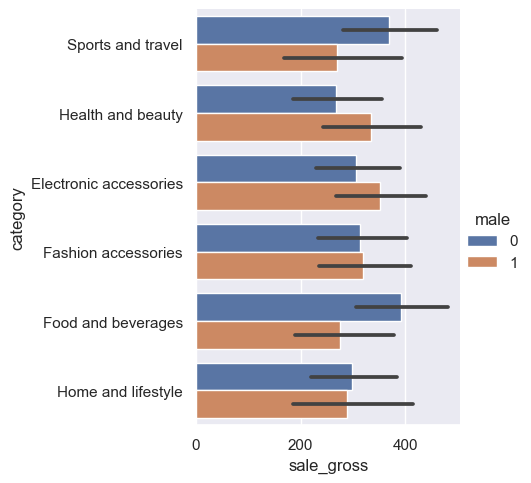

In [81]:
# female vs male sale gross by category at Naypyitaw branch
sns.catplot(
    data= naypyitaw,
    y= 'category',
    x= 'sale_gross',
    hue = 'male',
    kind= 'bar'
);

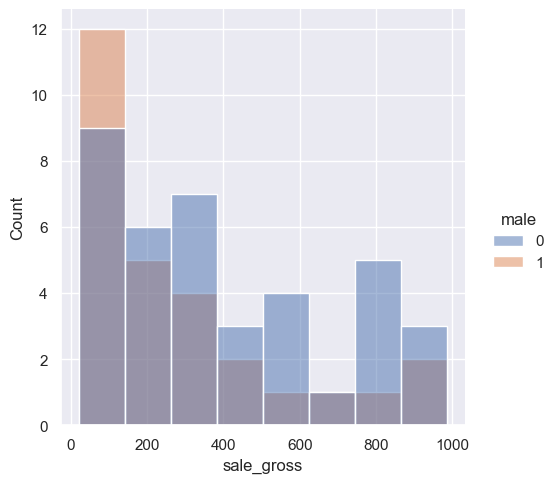

In [82]:
# 'Food and beverages' sale grosses for male vs female
sns.displot(
    data= naypyitaw.loc[naypyitaw['category'] == 'Food and beverages'],
    x= 'sale_gross',
    hue= 'male'
);

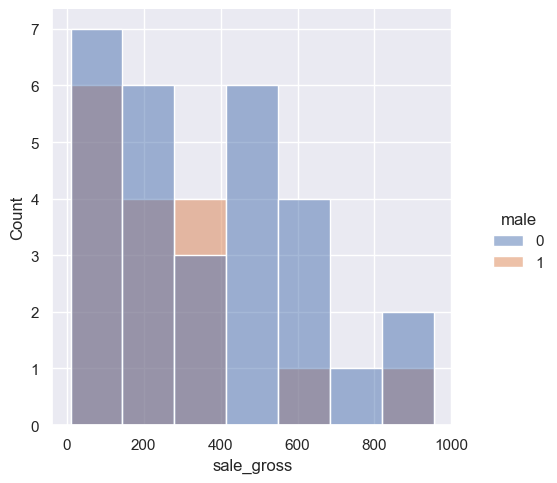

In [83]:
# 'Sports and travel' sale grosses for male vs female
sns.displot(
    data= naypyitaw.loc[naypyitaw['category'] == 'Sports and travel'],
    x= 'sale_gross',
    hue= 'male'
);

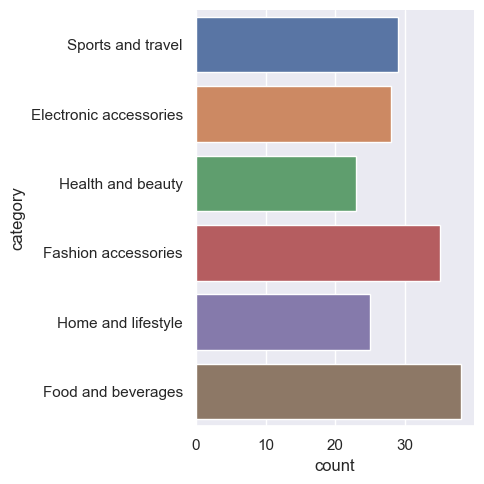

In [84]:
# female transactions by category at Naypyitaw branch
sns.catplot(
    data= supermarket_data.loc[
        (supermarket_data['branch'] == 'Naypyitaw') & \
        (supermarket_data['male'] == 0)
    ],
    y= 'category',
    kind= 'count'
);

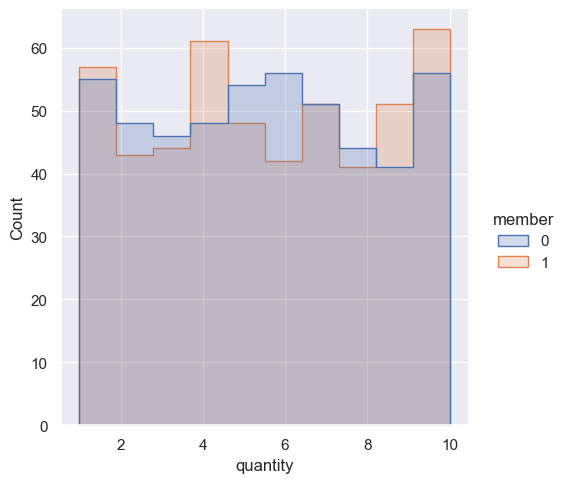

In [85]:
# distribution of quantity per transaction vs member
sns.displot(
    data= supermarket_data,
    x= 'quantity',
    hue= 'member',
    element= 'step',
    bins= 10,
    kind= 'hist'
);

### CATEGORY
- Most high value transactions occur in 'Food and beverages'.
- 'Electronic accessories' have lowest overall distribution of high-value transactions.
- 'Sports and travel' has the highest mean sale_gross of high-value transactions.
- Quantity by category: 'Food and beverages', 'Home and lifestyle', and 'Sports and travel' were all high-quantity performers. Significantly higher than mean?
- Comperable total sales amounts by category. Health and beauty was worst performer.
- No apparent relationship between quantity and sale_gross for any category.

### TIME
- Test if mean sales on any particular day are significantly higher than the average. May need to transform the data to normalize the skew.
- No apparent changes in sales amounts across observation time span.
- Significant number of member transactions occur 1800-1900 hours at Mandalay branch. Mandalay also suffers worst performing hours at 1000, 1500 and 1600 hours.

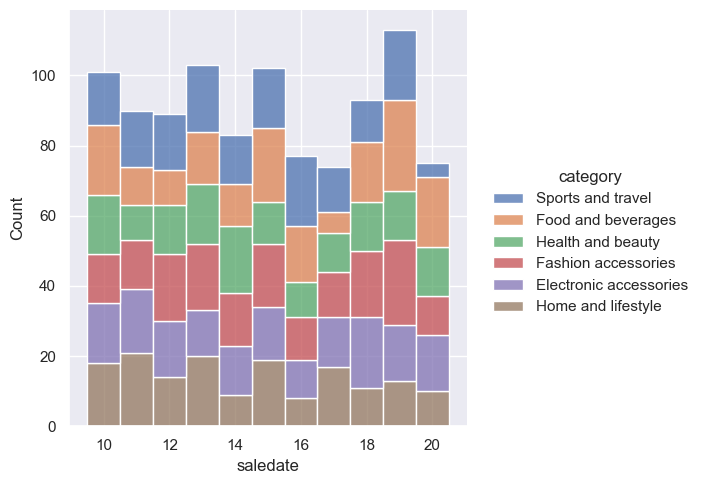

In [86]:
# total transactions by hour by category
sns.displot(
    data= supermarket_data,
    x= supermarket_data.index.hour,
    hue= 'category',
    multiple= 'stack',
    discrete= True
);

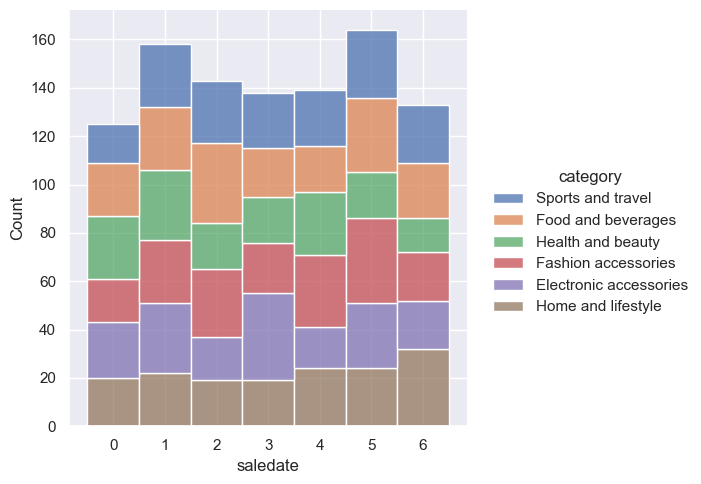

In [87]:
# total transactions by day by category
g = sns.displot(
    data= supermarket_data,
    x= supermarket_data.index.day_of_week,
    hue= 'category',
    multiple= 'stack',
    discrete= True
)